In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso,Ridge

## Part 0) Import data, construct A and B.

I was having issues downloading the dataset using the link provided in the assignment, so I downloaded the MNIST training and test data from another source.

In [2]:
#Load the data
testdata = np.loadtxt("MNIST dataset\\mnist_test.csv",delimiter=",")
traindata = np.loadtxt("MNIST dataset\\mnist_train.csv",delimiter=",")

In [3]:
#Construct A
A_train = traindata[:,1:] #vectorized images
labels = traindata[:,0] #labels (as raw numbers i.e. 0-9)

#Build B matrix from the labels. Each scalar label (e.g. "0") becomes a vector (e.g. [1 0 0 ... 0]) row in B
B_train = [] #initialize
for i in range(len(labels)):
    yj = np.zeros(10)
    yj[int(labels[i])] = 1 #Put a one in the right place.
    B_train.append(yj)
B_train = np.array(B_train).reshape(A_train.shape[0],10)

#Repeat for test data:
A_test = testdata[:,1:] #vectorized images
labels_test = testdata[:,0] #labels (as raw numbers)

#Build B matrix from the labels. Each scalar label (e.g. "0") becomes a vector (e.g. [1 0 0 ... 0]) row in B
B_test = [] #initialize
for i in range(len(labels_test)):
    yj = np.zeros(10) 
    yj[int(labels_test[i])] = 1 #Put a one in the right place.
    B_test.append(yj)
B_test = np.array(B_test).reshape(A_test.shape[0],10)

Next, I will define a helper function test() to calculate AX, then compare the results to B. Essentially, each row of AX will be a 1x10 vector with different weights for each number 0-9 in order. I will take the maximum weight in each row to be the correct number (i.e. if the largest digit is in the 0th place, I will set that to 1 and the rest to 0). Then, I will compare each row to the true value of B and calculate how many are correct, from 0-100%.

In [4]:
#Check solution for X against test data A & B:
def test(A,X,B,name):
    #Solve for B using test data & solution X
    Btemp = A @ X 

    match=[]
    for j in range(len(B)): #For each line in B
        match.append(np.allclose((Btemp[j]==Btemp[j].max()),B[j])) #Check if AX=B. Append 'True' or 'False' to a list

    acc = match.count(True)/len(match) #Accuracy of the model is the number of True entries divided by the number of rows in B.
    print("{} is {:.2f}% accurate".format(name,acc*100))

In [5]:
#Helper function: Plot each column of X to visualize each digit
def Xplot(X):
    fig, ax = plt.subplots(2,5,figsize=(12,5),sharex=True,sharey=True)
    for j in range(0,5): #first row
        ax[0,j].imshow(X[:,j].reshape(28,28),"Greys")
    for j in range(5,10): #2nd row
        ax[1,j-5].imshow(X[:,j].reshape(28,28),"Greys")

# Part 1) Solving A X = B

## a) Psuedoinverse:

In [6]:
Apinv = np.linalg.pinv(A_train) #Pseudo inverse of A
Xpinv = Apinv @ B_train #Calculate X = pinv(A) B using training data

#Check accuracy of model using training data; testing data
test(A_train,Xpinv,B_train,'Pseudoinverse model with training data')
test(A_test,Xpinv,B_test,'Pseudoinverse model with test data')

Pseudoinverse model with training data is 85.19% accurate
Pseudoinverse model with test data is 85.34% accurate


## b) SVD

A = U S V^T? True
SVD model with training data is 67.18% accurate
SVD model with test data is 68.04% accurate


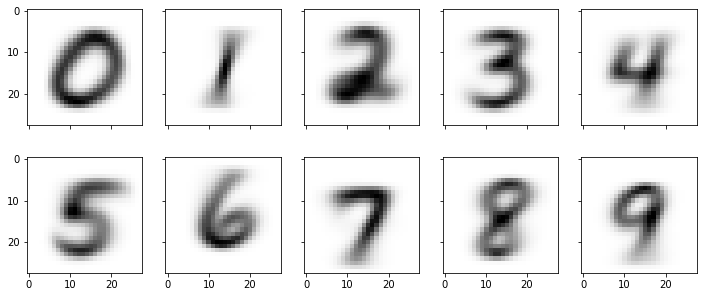

In [7]:
# Decompose A = U S V^T
U,S,VT = np.linalg.svd(A_train,full_matrices=False)
# X = V S U^T * B
Xsvd = VT.T @ np.diag(S).T @ U.T @ B_train

#Check that U S VT = A
print("A = U S V^T? {}".format(np.allclose(U @ np.diag(S) @ VT,A_train)))

#Check accuracy of model using training data; testing data
test(A_train,Xsvd,B_train,'SVD model with training data')
test(A_test,Xsvd,B_test,'SVD model with test data')
Xplot(Xsvd) #helper function, defined above

Wow, look at those nice, clear numbers! These are the rows of Xsvd reshaped and plotted on a heat map.

## c ) Least squares

In [8]:
#Least Squares
X_ls = np.linalg.lstsq(A_train,B_train,rcond=None)[0]

#Check accuracy
test(A_train,X_ls,B_train,'Least Squares model with training data')
test(A_test,X_ls,B_test,'Least Squares model with test data')

Least Squares model with training data is 85.19% accurate
Least Squares model with test data is 85.34% accurate


## d) Lasso: regularization using L1 norm

Lasso model on training data is is 77.15% accurate
Lasso model on test data is is 77.70% accurate


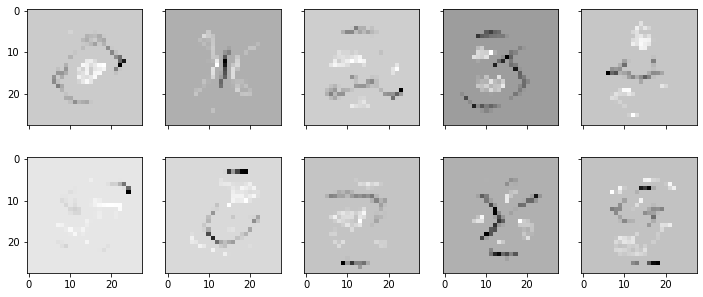

In [9]:
lasso = Lasso() #alpha = 1 be default. See sections 2 & 4 for varying sparcity.
lasso.fit(A_train,B_train)
Xlasso = lasso.coef_ 

test(A_train,Xlasso.T,B_train,'Lasso model on training data is')
test(A_test,Xlasso.T,B_test,'Lasso model on test data is')
Xplot(Xlasso.T)

## e) Ridge: regularization using L2 norm

In [10]:
ridge = Ridge() #alpha = 1 by default.
ridge.fit(A_train,B_train)
Xridge = ridge.coef_ 

test(A_train,Xridge.T,B_train,'Ridge model on training data is')
test(A_test,Xridge.T,B_test,'Ridge model on test data is')

Ridge model on training data is is 81.36% accurate
Ridge model on test data is is 81.15% accurate


# 2) Promoting Sparcity

For this section, we are testing the model's ability to identify numbers overall. For a more detailed look at how the model identifies each digit individually, see part 4) below. 

NOTE: I actually solved question 4 first becuase it was what made sense to me given the data. I'm not entirely sure what this question is looking for, since the analysis done in part 4 is much more robust, but I will do my best to answer the question as written.

We will use the Lasso function to promote sparcity. The scikit learn uses this objective function for Lasso:

$(1 / (2 * n_{samples})) * ||B - AX||^2_2 + alpha * ||X||_{1}$

Where $||B - AX||^2_2$ is the objective function and $alpha * ||X||_1$ is the regularization term. By increasing alpha, we increase the L1 penalty and promote sparcity.

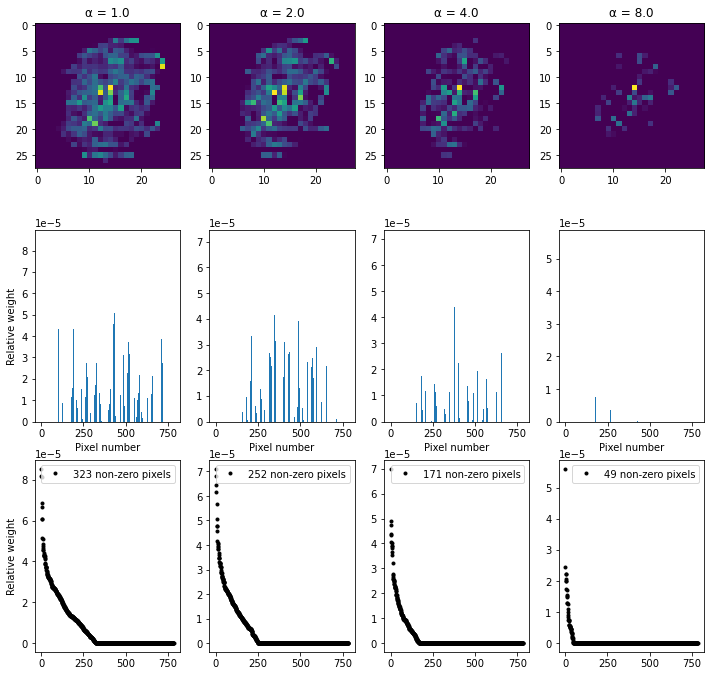

In [11]:
fig, ax = plt.subplots(3,4,figsize=(12,12))
c=0
for l in [1.0,2.0,4.0,8.0]: #increase alpha to to promote sparcity
    lasso = Lasso(alpha=l) #Create lasso obj
    lasso.fit(A_train,B_train) #Find fit for AX=B
    Xlasso = lasso.coef_  #Define X
    Xgen = np.mean(abs(Xlasso),axis=0) #Average across all pixels to find the most important ones
    mask=np.nonzero(Xgen) #find locations of important pixels
    
    #plot heatmap
    ax[0,c].imshow(Xgen.reshape(28,28)) 
    
    #Plot bars of most important pixels
    nzpix = np.count_nonzero(Xgen[:]) #count the number of nonzero pixels
    ax[1,c].bar(range(len(Xgen)),Xgen,label=str(nzpix)+' pixels used')
    ax[1,c].set_xlabel('Pixel number')
    
    #Plot pixel importance & dropoff
    Xsort = np.flip(np.sort(Xgen))
    ax[2,c].plot(range(len(Xsort)),Xsort,'k.',label=str(nzpix)+" non-zero pixels")
    ax[2,c].legend()
    ax[0,c].set_title('\u03B1 = '+str(l));
    c+=1
ax[1,0].set_ylabel('Relative weight')
ax[2,0].set_ylabel('Relative weight');

Row 1: A heatmap shows the most imporant pixels as the alpha parameter (proxie for sparcity) increases. As alpha increases, pixels are "turned off" (set to zero) and only the most important pixels remain. Row 2 ranks the pixels by their relative importance in mapping A -> B. Row 3 shows them in order to visualize the drop off & zero vs. non-zero entries. 

# 3) Applying the most important pixels

Next, we will apply just the most important pixels for different levels of sparcity and check the accuracy of each.

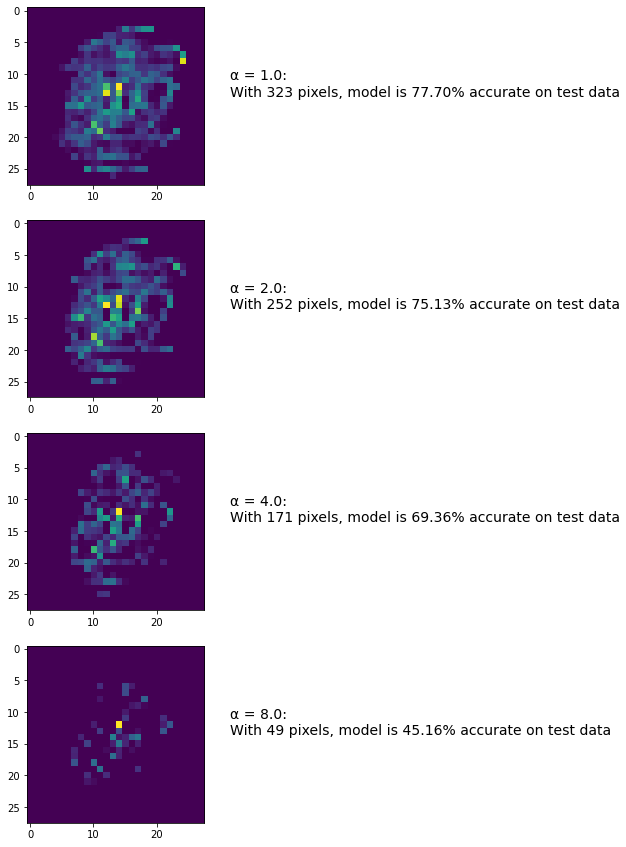

In [15]:
fig, ax = plt.subplots(4,2,figsize=(10,15))
c=0
for l in [1.0,2.0,4.0,8.0]: #increase alpha to to promote sparcity
    lasso = Lasso(alpha=l) #Create lasso obj
    lasso.fit(A_train,B_train) #Find fit for AX=B
    Xlasso = lasso.coef_  #Define X
    Xgen = np.mean(abs(Xlasso),axis=0) #Average across all pixels to find the most important ones
    mask=np.nonzero(Xgen) #find locations of important pixels
    nzpix = np.count_nonzero(Xgen[:]) #count the number of nonzero pixels
    
    #plot heatmap with unimportant pixels turned off
    ax[c,0].imshow(Xgen.reshape(28,28)) 
    
    #Calculate accuracy
    Btemp = A_test @ Xlasso.T 
    match=[]
    for j in range(len(B_test)): #For each line in B
        match.append(np.allclose((Btemp[j]==Btemp[j].max()),B_test[j])) #Check if AX=B for each B row. Append 'True' or 'False' to a list
    acc = match.count(True)/len(match) #Accuracy of the model is the number of True entries divided by the number of rows in B.
    
    #Add text next to image
    msg="\u03B1 = {}:\nWith {} pixels, model is {:.2f}% accurate on test data".format(l,nzpix,acc*100)
    ax[c,1].text(-0.25,0.5,msg,fontsize=14)
    ax[c,1].axis('off')

    c+=1

Even using less than half of the pixels (323 pixels at alpha=1.0), the model gets it right 77% of the time. This is pretty good compared to our best method (pseudoinverse), which is right 85% of the time. This shows how you can filter out unimportant pixels to focus on just the spots that matter.

Using just 171 pixels (just 22% of the original pixels!) we still get the number right ~70% of the time, which is pretty amazing. However, at the extreme when we use just 49 pixels the accuracy plummets to 45%, which is no longer good.

# 4) Promoting Sparcity (individual digit analysis)

i) Vary sparcity by changing the alpha parameter in Lasso function. Higher alpha = more sparcity. Then, reshape and plot the rows of X to visualize the most important pixels for each digit. Also, check how accurate the model is overall.

Lasso (α = 0.1) training is 80.51% accurate
Lasso (α = 0.1) test is 80.87% accurate
Lasso (α = 0.5) training is 78.61% accurate
Lasso (α = 0.5) test is 79.17% accurate
Lasso (α = 1.0) training is 77.15% accurate
Lasso (α = 1.0) test is 77.70% accurate
Lasso (α = 2.0) training is 74.78% accurate
Lasso (α = 2.0) test is 75.13% accurate
Lasso (α = 4.0) training is 69.10% accurate
Lasso (α = 4.0) test is 69.36% accurate


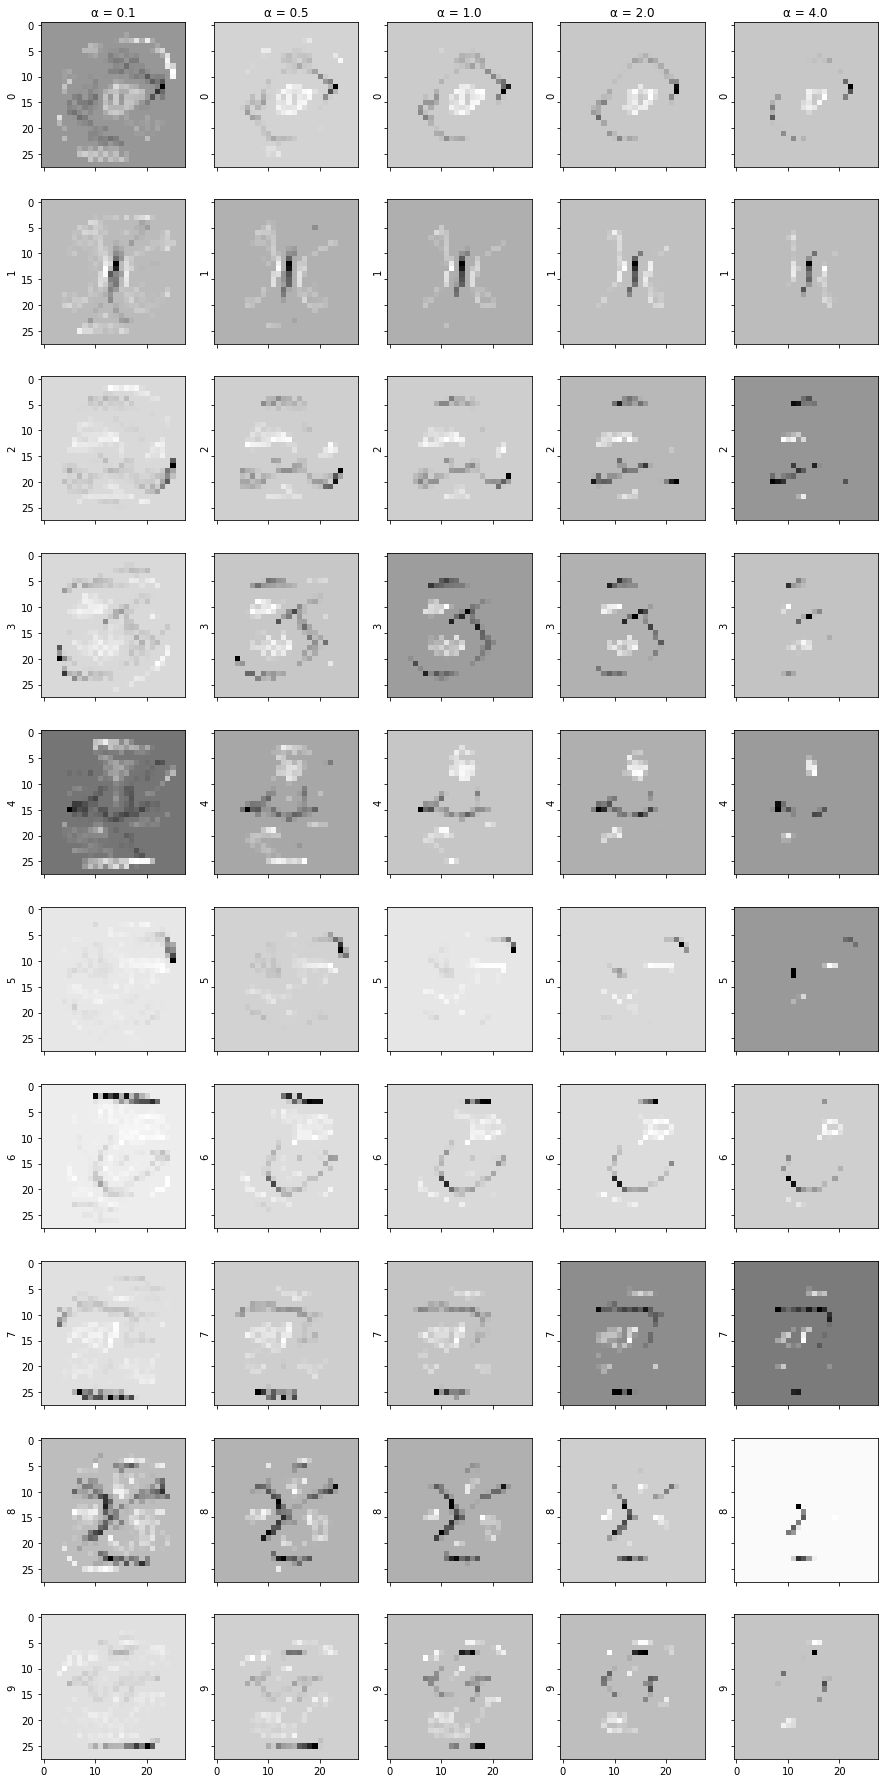

In [13]:
fig, ax = plt.subplots(10,5,figsize=(15,32),sharex=True,sharey=True)
c=0
for l in [0.1,0.5,1.0,2.0,4.0]: #Increase Lambda to to promote sparcity
    lasso = Lasso(alpha=l) #Create lasso obj
    lasso.fit(A_train,B_train) #Find fit for AX=B
    Xlasso = lasso.coef_  #Define X
    test(A_train,Xlasso.T,B_train,'Lasso (\u03B1 = {}) training'.format(l)) #Check accuracy
    test(A_test,Xlasso.T,B_test,'Lasso (\u03B1 = {}) test'.format(l)) #Check accuracy
    
    for i in range(10): #For each digit
        ax[i,c].imshow(Xlasso[i,:].reshape(28,28),"Greys") #reshape & plot
        ax[i,c].set_ylabel(str(i))
    ax[0,c].set_title('\u03B1 = '+str(l));
    c+=1

In these plots, the dark pixels (positive values) are where the presence of writing is used to identify the digit. Conversely, the white pixels (negative values) are where a LACK of writing is characteristic of a certain digit. For example, if your digit is a zero, it probably has a dark ring and nothing in the center! The background gray color (which is different for each image because it depends on the min/max values for that image) cooresponds to zero, AKA a pixel that has been "turned off" by the Lasso method promoting sparcity. 
Some digits become more clear with high sparcity (e.g. 2 and 3), some digits become less clear (e.g. 6 and 8), and some aren't very clear at any sparcity (e.g. 5).

Another way to visualize this is to look at the pixel intensity plotted on a bar chart. This will show us the most important pixels & their relative importance (more important = taller bar). We will also count how accurate we are with fewer pixels.

Lasso method (α = 0.5) on test data is 79.17% accurate
Lasso method (α = 2.0) on test data is 75.13% accurate
Lasso method (α = 4.0) on test data is 69.36% accurate


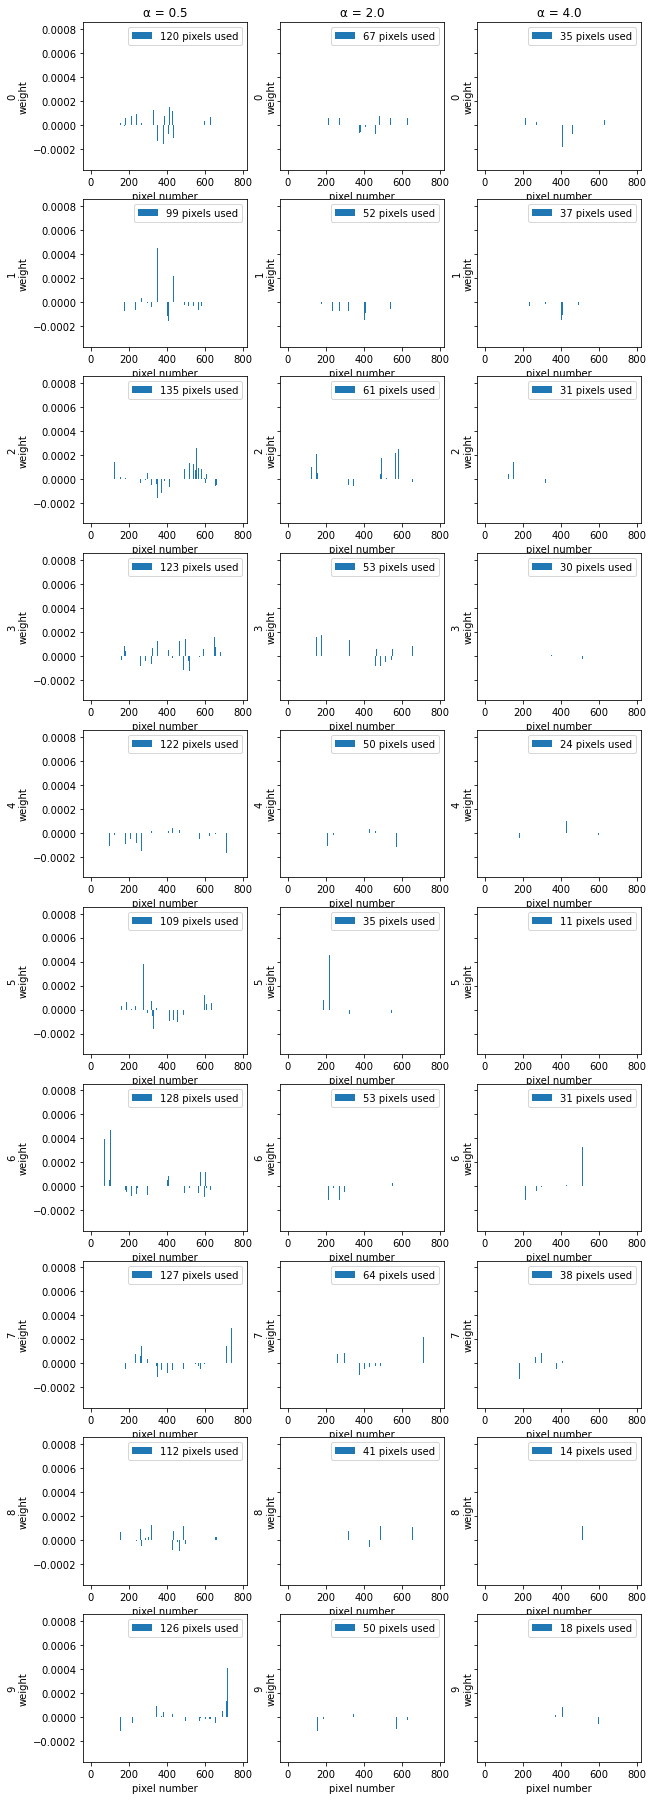

In [16]:
fig, ax = plt.subplots(10,3,figsize=(10,32),sharey=True) #Create figure

c=0
for l in [0.5,2.0,4.0]: #Decrease Lambda to to promote sparcity
    lasso = Lasso(alpha=l) #Create lasso obj with sparcity-inducing term alpha = l
    lasso.fit(A_train,B_train) #Find fit for AX=B
    Xlasso = lasso.coef_  #Define X
    
    #"Apply your most important pixels to the test data set to see how accurate you are with as few pixels as possible."
    test(A_test,Xlasso.T,B_test,'Lasso method (\u03B1 = {}) on test data'.format(l)) 
    
    ax[0,c].set_title('\u03B1 = '+str(l));1
    for i in range(10): #Plot pixel vs. intensity for each 
        nzpix = np.count_nonzero(Xlasso[i,:]) #count the number of nonzero pixels
        ax[i,c].bar(range(Xlasso.shape[1]),Xlasso[i,:],label=str(nzpix)+' pixels used') 
        ax[i,c].legend()
        ax[i,c].set_xlabel('pixel number')
        ax[i,c].set_ylabel(str(i)+'\nweight')
    c+=1

We can see that as alpha increases, sparcity increases and the Lasso method sets many more pixels to zero. This comes at the cost of some accuracy. 

Using ~115 pixels at alpha=0.5, the model is 79.17% accurate overall.
Using ~50 pixels at alpha=2.0, the model is 75.13% accurate overall.
Using ~20 pixels at alpha=4.0, the model is 69.36% accurate overall.

Notice how we need many fewer pixels than part 3) when dealing with each digit individually! 

With this in mind, I would say using the top ~100 most important pixels is a great way to cut down on data you need to store without compromising too much on accuracy. It's still pretty surprising that with only ~25 pixels, we can get ~70% accuracy!

# 5) Thinking about interpretation

In this assignment, we are practicing different ways to solve AX=B for mapping images of handwritten digits to a digit 0-9. Instead of mapping directly to a number 0-9, we use vectors [1,0,0...], [0,1,0,...]  etc. because they are orthogonal to each other as opposed to a non-orthogonal scalar. 

In addition to solving AX=B, we are figuring out how to solve the equation as efficiently and quickly as possible. This means honing in on which pixels are most important and ignoring the rest. In part 2, we do this by promoting sparcity through the regularization term in the minimization equation in the Lasso method. By imposing a stronger L1 penalty through increasing alpha, we drop unimportant pixels to zero and only focus on the ones most important to our model. Promoting sparcity also helps guard against over-fitting data, and we can see from the accuracy of our test data that we have not overfit. In part 3, we find that we are able to effectively map A -> with relatively few pixels (~1/2 the total)

Then, in Part 4 we start considering the individual digit mappings stored within X. By doing this, we are able to hone in on the very few most important pixels to each digit, without sacrificing much accuracy. Using far fewer pixels than parts 2&3, we demonstrate the effectiveness of sparse mapping. For me, the coolest part of the homework was plotting the heat maps of the X matrix and seeing exactly which pixels my code is looking at to determine the number, and seeing how recognizable the patterns are (e.g. 0s, 2s, 3s) to my human eyes.

